In [72]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from PIL import Image
from typing import Sequence
from matplotlib.figure import Figure
from random import randint

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_config_yaml

BBox = Sequence[float]

paths = load_config_yaml('../path_config.yml')

In [11]:
save_fig_path = paths['figures']

cm = 1 / 2.54  # cm to inch conversion

plt.rcParams['axes.titlesize'] = 10  # Adjust the size of the title
plt.rcParams['axes.labelsize'] = 8  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 6  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Adjust the size of the y-axis tick labels
plt.rcParams['font.size'] = 8  # General font size for all text elements
plt.rcParams['legend.fontsize'] = 6  # Font size for legend text

# Set global line width for axes and ticks
plt.rcParams['axes.linewidth'] = 0.2  # Adjust the thickness of the axes frame lines
plt.rcParams['xtick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the x-axis
plt.rcParams['ytick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the y-axis
plt.rcParams['xtick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the x-axis
plt.rcParams['ytick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the y-axis

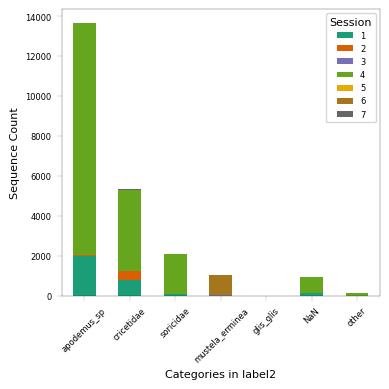

In [ ]:
########################################################################################################################
# Plot available Sequences per Label
fig_name = "label2_session.pdf"
fig_size = (10*cm,10*cm)
########################################################################################################################

label_files = paths['labels'].glob('*.csv')

df = pd.DataFrame()

for file in label_files:
    df = pd.concat([df, pd.read_csv(file)], ignore_index=True)

df["label2"] = df["label2"].fillna("NaN")

counts = df.groupby(["label2", "session"]).size().unstack(fill_value=0)
counts["total"] = counts.sum(axis=1)

special_labels = ["NaN", "other"]

regular = counts[~counts.index.isin(special_labels)].sort_values("total", ascending=False)
special = counts[counts.index.isin(special_labels)]

counts_sorted = pd.concat([regular, special])
counts_sorted = counts_sorted.drop(columns="total")

# Create figure
fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[1]))

counts_sorted.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Dark2"
)

ax.set_xlabel("Categories in label2")
ax.set_ylabel("Sequence Count")
ax.tick_params(axis='x', rotation=45)
ax.legend(title="Session", loc='upper right')

plt.tight_layout()
plt.savefig(save_fig_path / fig_name, dpi=300)

plt.show()


### Image Level Evaluation

In [ ]:
dataset_img = MammaliaDataImage(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=None,
)

/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:227: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(


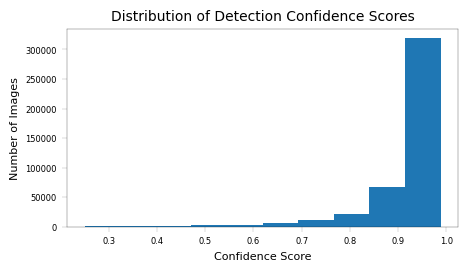

In [ ]:
########################################################################################################################
# Plot Histogram of Detection Confidence Scores
fig_name = 'detection_conf_hist.pdf'
fig_size = (12*cm,7*cm)
########################################################################################################################

df = dataset_img.ds

plt.figure(figsize=fig_size)
plt.hist(df['conf'], bins=10)
plt.title('Distribution of Detection Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

### Sequence Level Evaluation

In [30]:
dataset_seq = MammaliaDataSequence(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=None,
)

/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:227: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(


In [130]:
print(dataset_img.ds)

         seq_id  class_id       label2    SerialNumber  \
0       3000000       0.0  apodemus_sp  H550HF07158839   
1       3000000       0.0  apodemus_sp  H550HF07158839   
2       3000000       0.0  apodemus_sp  H550HF07158839   
3       3000000       0.0  apodemus_sp  H550HF07158839   
4       3000000       0.0  apodemus_sp  H550HF07158839   
...         ...       ...          ...             ...   
436647  4018687       1.0   cricetidae  H550HF08161368   
436648  4018687       1.0   cricetidae  H550HF08161368   
436649  4018688       3.0    soricidae  H550HF08161368   
436650  4018688       3.0    soricidae  H550HF08161368   
436651  4018688       3.0    soricidae  H550HF08161368   

                                       file_path  \
0            sessions/session_03/28/IMG_0016.JPG   
1            sessions/session_03/28/IMG_0018.JPG   
2            sessions/session_03/28/IMG_0019.JPG   
3            sessions/session_03/28/IMG_0017.JPG   
4            sessions/session_03/28/IMG_000

In [32]:
dataset_img[0]

{'x': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536>,
 'y': 0.0,
 'class_name': 'apodemus_sp',
 'bbox': [0.0888, 0.5299, 0.3642, 0.1979],
 'conf': 0.979,
 'seq_id': 3000000,
 'file_path': PosixPath('sessions/session_03/28/IMG_0016.JPG')}

In [70]:
def plot_image_with_bbox(
        image: Image.Image, 
        bbox: BBox,
        conf: float | None = None) -> Figure:

    width, height = image.size

    x_abs = bbox[0] * width
    y_abs = bbox[1] * height
    w_abs = bbox[2] * width
    h_abs = bbox[3] * height

    fig, ax = plt.subplots()
    ax.imshow(image)

    rect = patches.Rectangle(
        (x_abs, y_abs), w_abs, h_abs,
        linewidth=1, edgecolor='red', facecolor='none'
    )

    ax.add_patch(rect)

    if conf is not None:
        ax.text(
            x_abs + 5, y_abs - 10,
            f"conf = {conf:.2f}",
            fontsize=8,
            color='white',
            bbox=dict(facecolor='red', alpha=0.5, edgecolor='none', pad=1.5)
        )

    ax.axis('off')
    plt.tight_layout()

    plt.close(fig)

    return fig


Randomly selected index: 108812


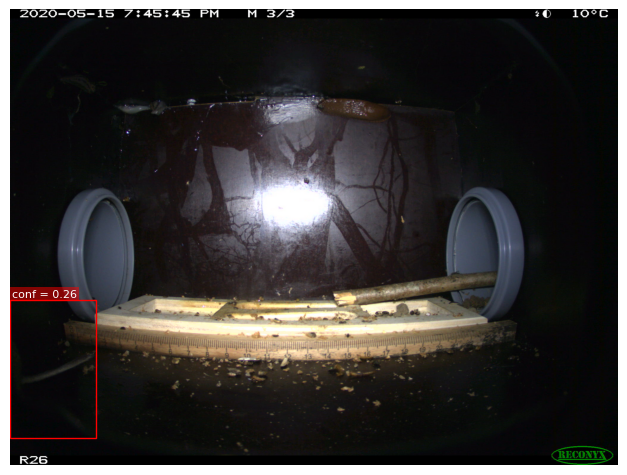

In [128]:
i = randint(0, len(dataset_img) - 1)
print(f"Randomly selected index: {i}")
sample = dataset_img[i]

plot_image_with_bbox(image=sample['x'], bbox=sample['bbox'], conf=sample['conf'])


In [ ]:
108812

In [137]:
from IPython.display import display


In [ ]:
lowest_conf_indices = dataset_img.ds.nsmallest(20, 'conf').index.tolist()

for i in lowest_conf_indices:
    sample = dataset_img[i]
    figure = plot_image_with_bbox(image=sample['x'], bbox=sample['bbox'], conf=sample['conf'])
    display(figure)
    